In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns
import pickle 


### Get Data


- Abnormal Data Class = 1
- Normal Data Class = 0


In [2]:
#reading csv file
df = pd.read_csv("Datasets/fan_0db.csv")
df.shape

(5550, 16)

In [3]:
df.head()

,file_name,y_min,y_max,y_mean,y_std,zcr_mean,zcr_min,zcr_max,spec_cent_min,spec_cent_mean,rms_mean,amp_mean,amp_min,melspec_mean,melspec_std,class
0,Audio_Files/0dB_fan/id_00/abnormal/00000059.wav,-0.032230,0.029817,-6.926849e-07,0.009295,0.031904,0.016113,0.054688,1056.230929,1195.770358,0.009263,0.020296,0.012419,0.020323,0.119019,1
1,Audio_Files/0dB_fan/id_00/abnormal/00000071.wav,-0.034450,0.028665,-6.027881e-07,0.009493,0.021894,0.009766,0.034668,703.965079,800.327823,0.009442,0.020580,0.013375,0.021241,0.128594,1
2,Audio_Files/0dB_fan/id_00/abnormal/00000065.wav,-0.034897,0.028662,5.634240e-06,0.009543,0.027962,0.010742,0.047852,871.776362,998.865525,0.009508,0.020938,0.015119,0.021519,0.125431,1
3,Audio_Files/0dB_fan/id_00/abnormal/00000273.wav,-0.024785,0.026773,5.817374e-07,0.006059,0.057802,0.017578,0.087402,1112.632569,1419.440256,0.006014,0.016007,0.010261,0.008460,0.032597,1
4,Audio_Files/0dB_fan/id_00/abnormal/00000267.wav,-0.034780,0.037046,1.282572e-06,0.004874,0.049731,0.016602,0.279785,771.766407,1154.008254,0.004715,0.012308,0.005732,0.005148,0.024881,1


In [4]:
# drop unnecessary data
df = df.drop(columns = 'file_name')

X = df.drop(columns = 'class')
y = df['class']


In [5]:
count = df['class'].value_counts()
count

0    4075
1    1475
Name: class, dtype: int64

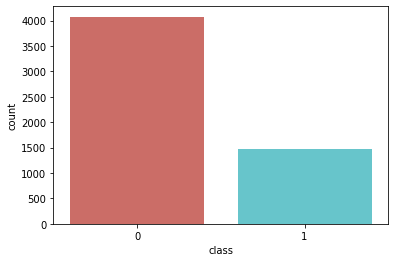

In [6]:
sns.countplot(x='class',data= df, palette= 'hls')
plt.show()

### Split Data

In [7]:
# Split dataset train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Standard Scaler

- Standardizing a dataset involves rescaling the distribution of values so that the mean of observed values is 0 and the standard deviation is 1.

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Random Forest

- Random forests is considered as a highly accurate and robust method because of the number of decision trees participating in the process
- The algorithm can be used in both classification and regression problems.
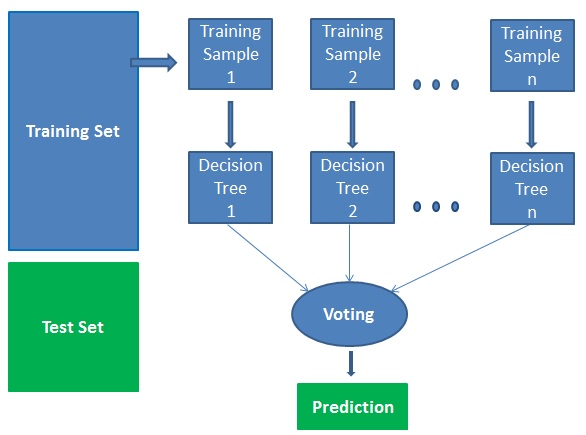
- Random forests is slow in generating predictions because it has multiple decision trees. Whenever it makes a prediction, all the trees in the forest have to make a prediction for the same given input and then perform voting on it. This whole process is time-consuming.

In [9]:
rf =  RandomForestClassifier(n_estimators= 100, class_weight='balanced')
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced')

In [10]:
# Predict
y_pred = rf.predict(X_test)


In [11]:
y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [12]:
#Evaluation of the model

print('Test accuracy for Random Forest is:',metrics.accuracy_score(y_test,y_pred)*100)

Test accuracy for Random Forest is: 91.7117117117117


In [13]:
print('\nConfusion matrix:\n',metrics.confusion_matrix(y_test,y_pred))


Confusion matrix:
 [[785  12]
 [ 80 233]]


In [14]:
print('\n Classification Report: \n',metrics.classification_report(y_test,y_pred))


 Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.98      0.94       797
           1       0.95      0.74      0.84       313

    accuracy                           0.92      1110
   macro avg       0.93      0.86      0.89      1110
weighted avg       0.92      0.92      0.91      1110



### ROC CURVE

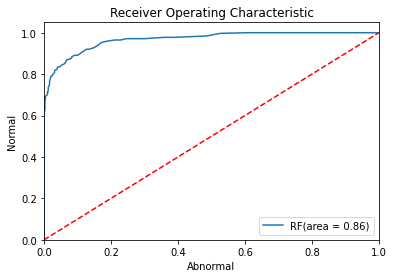

In [15]:
logit_roc_auc = roc_auc_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test,rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RF(area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Abnormal')
plt.ylabel('Normal')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC_Curve_RF')
plt.show()

### Cross Validation

In [16]:
accuracies = cross_val_score(estimator = rf, X = X, y = y, cv=10)
AccuraciesMean = accuracies.mean()*100
StandardDeviation = accuracies.std()*100

print("%0.2f mean accuracy with a standard deviation of %0.2f" % (AccuraciesMean, StandardDeviation))


90.97 mean accuracy with a standard deviation of 5.29


In [17]:
accuracies

array([0.87747748, 0.86306306, 0.8954955 , 0.87387387, 0.84684685,
       0.91711712, 0.86846847, 0.96756757, 0.98738739, 1.        ])

In [18]:
def check_overfitting(range_number):
    train_scores, test_scores = list(), list()
    values = [i for i in range(1, range_number)]
    for i in values:
        model = RandomForestClassifier(n_estimators= 100, class_weight='balanced')
        model.fit(X_train, y_train)
        # train accuracy 
        x_pred = model.predict(X_train)
        train_acc = metrics.accuracy_score(y_train, x_pred)
        train_scores.append(train_acc)
        #test accuracy
        y_pred = model.predict(X_test)
        test_acc = metrics.accuracy_score(y_test, y_pred)
        test_scores.append(test_acc)
        print("{},    Train: {},   Test: {}".format(i, train_acc, test_acc))
        
    plt.plot(values, train_scores, '-o', label='Train')
    plt.plot(values, test_scores, '-o', label='Test')
    plt.legend()
    plt.show()
         

1,    Train: 1.0,   Test: 0.9144144144144144
2,    Train: 1.0,   Test: 0.918918918918919
3,    Train: 1.0,   Test: 0.918918918918919
4,    Train: 1.0,   Test: 0.9207207207207208
5,    Train: 1.0,   Test: 0.9207207207207208
6,    Train: 1.0,   Test: 0.9126126126126126
7,    Train: 0.9997747747747747,   Test: 0.918918918918919
8,    Train: 1.0,   Test: 0.9207207207207208
9,    Train: 1.0,   Test: 0.9144144144144144


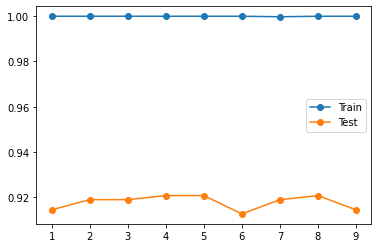

In [19]:
check_overfitting(10)

### Feature Selection

- Variance Threshold Feature Selection
- Univariate Selection using SelectKBest
- Recursive Feature Elimination or RFE
- SelectFromModel
- Sequential Feature Selection or SFS

In [20]:
feature_imp = pd.Series(rf.feature_importances_,index=X.keys()).sort_values(ascending=False)
feature_imp

amp_mean          0.125514
melspec_std       0.121404
y_std             0.109766
melspec_mean      0.102946
rms_mean          0.099839
spec_cent_mean    0.084121
spec_cent_min     0.066652
zcr_mean          0.064614
y_min             0.051571
zcr_max           0.043748
y_max             0.043703
amp_min           0.035201
zcr_min           0.026394
y_mean            0.024527
dtype: float64

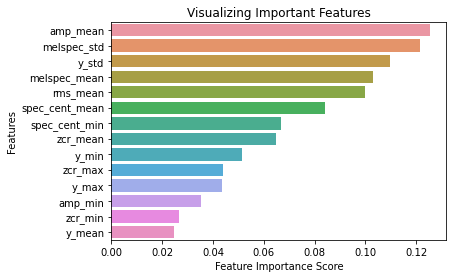

In [21]:
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Create New Model With Reduces Features

In [22]:
X = df[['amp_mean','melspec_std','y_std', 'rms_mean', 
        'melspec_mean', 'spec_cent_mean','spec_cent_min',
        'zcr_mean','y_min','amp_min']]
y = df['class']

### Split Data


In [23]:
# Split dataset train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


### Feature Scaling : Standard Scaler

In [24]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Model

In [25]:
rf =  RandomForestClassifier(n_estimators= 100, class_weight='balanced')
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced')

In [26]:
# Predict
y_pred = rf.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 1])

In [27]:
#Evaluation of the model

print('Test accuracy for Random Forest is:',metrics.accuracy_score(y_test,y_pred)*100)

Test accuracy for Random Forest is: 91.8918918918919


In [28]:
print('\nConfusion matrix:\n',metrics.confusion_matrix(y_test,y_pred))


Confusion matrix:
 [[802  14]
 [ 76 218]]


In [29]:
print('\n Classification Report: \n',metrics.classification_report(y_test,y_pred))


 Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.98      0.95       816
           1       0.94      0.74      0.83       294

    accuracy                           0.92      1110
   macro avg       0.93      0.86      0.89      1110
weighted avg       0.92      0.92      0.92      1110



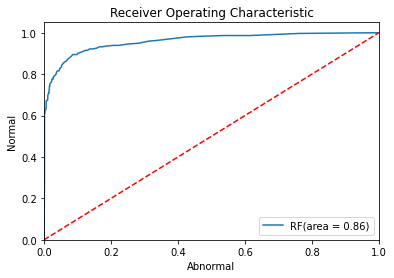

In [35]:
logit_roc_auc = roc_auc_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test,rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='RF(area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Abnormal')
plt.ylabel('Normal')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC_Curve_RF')
plt.show()

### Save Model

In [30]:
# save model
filename = 'fan_0db_rf.sav'
pickle.dump(rf, open(filename, 'wb'))


In [31]:
# try model
rf_model = pickle.load(open(filename, 'rb'))


In [32]:
result = rf_model.predict(X_test)

In [33]:
result

array([0, 0, 0, ..., 0, 0, 1])